# Репараметризация MobileOneBlock и ConvFFN в FastViT

Посмотрим, как в архитектуре **FastViT** реализован ускоряющий приём —
**репараметризация MobileOneBlock**, а также посмотрим на блок **ConvFFN**,
который заменяет обычный MLP в трансформерах на свёрточный вариант.


In [ ]:
!git clone -q https://github.com/apple/ml-fastvit.git /content/ml-fastvit
import sys, os
REPO = "/content/ml-fastvit"
assert os.path.isdir(REPO), "репозиторий не склонировался"
sys.path.append(REPO)
print("OK:", REPO)


fatal: destination path '/content/ml-fastvit' already exists and is not an empty directory.
OK: /content/ml-fastvit


## Что такое MobileOneBlock

`MobileOneBlock` — это строительный блок, который в **FastViT** является частью RepMixer, аналогом self-attention.  
Во время обучения он содержит **несколько параллельных ветвей**:

- **`rbr_conv`** — свёртка 3×3 с BatchNorm.
- **`rbr_scale`** — свёртка 1×1 с BatchNorm.
- **`rbr_skip`** — просто BatchNorm (skip-ветка).

Во время **инференса** эти ветви объединяются в одну свёртку,
эквивалентную сумме всех ветвей. Этот приём называется **репараметризация**.

На этапе тренировки несколько ветвей повышают устойчивость и качество обучения.
На этапе инференса всё это лишнее, и мы хотим сделать вычисление компактным.

$$
y = \text{BN}_{3x3}(W_3 * x) + \text{BN}_{1x1}(W_1 * x) + \text{BN}_{skip}(x)
$$

где * все операции линейные, поэтому их можно объединить в одну свёртку
с эквивалентными весами и смещением.


In [ ]:
import torch, inspect
from models.fastvit import MobileOneBlock

print(inspect.getsource(MobileOneBlock.reparameterize))


=== фрагмент reparameterize ===
    def reparameterize(self):
        """Following works like `RepVGG: Making VGG-style ConvNets Great Again` -
        https://arxiv.org/pdf/2101.03697.pdf. We re-parameterize multi-branched
        architecture used at training time to obtain a plain CNN-like structure
        for inference.
        """
        if self.inference_mode:
            return
        kernel, bias = self._get_kernel_bias()
        self.reparam_conv = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups,
            bias=True,
        )
        self.reparam_conv.weight.data = kernel
        self.reparam_conv.bias.data = bias

        # Delete un-used branches
        for para in self.parameters():
            para.detach_()
        self.__delattr__("rbr_conv")
 

In [ ]:
print(inspect.getsource(MobileOneBlock._get_kernel_bias))


=== фрагмент _get_kernel_bias ===
    def _get_kernel_bias(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Method to obtain re-parameterized kernel and bias.
        Reference: https://github.com/DingXiaoH/RepVGG/blob/main/repvgg.py#L83

        Returns:
            Tuple of (kernel, bias) after fusing branches.
        """
        # get weights and bias of scale branch
        kernel_scale = 0
        bias_scale = 0
        if self.rbr_scale is not None:
            kernel_scale, bias_scale = self._fuse_bn_tensor(self.rbr_scale)
            # Pad scale branch kernel to match conv branch kernel size.
            pad = self.kernel_size // 2
            kernel_scale = torch.nn.functional.pad(kernel_scale, [pad, pad, pad, pad])

        # get weights and bias of skip branch
        kernel_identity = 0
        bias_identity = 0
        if self.rbr_skip is not None:
            kernel_identity, bias_identity = self._fuse_bn_tensor(self.rbr_skip)

        # get weights and bias of co

### Как работает `reparameterize()`

1. **Проверка режима:** если блок уже в режиме инференса (`inference_mode=True`), выход.
2. **Получение ядра и смещения:** вызывается `_get_kernel_bias()`.  
   Этот метод:
   - Схлопывает `Conv+BN` каждой ветки в эквивалентный `Conv'` (формула ниже).
   - Для 1×1 ядра создаёт 3×3, у которого ненулевой элемент только в центре.
   - Преобразует BN(skip) в δ-ядро (identity kernel) 3×3 с bias.
   - Складывает все три 3×3 ядра и все bias’ы.
3. **Создаёт новый слой:** `nn.Conv2d(..., kernel_size=3, bias=True)`
   и копирует туда суммарные веса.
4. **Удаляет старые ветки:** `del rbr_conv, rbr_scale, rbr_skip`.
5. **Отмечает блок как `inference_mode=True`**.

Формулы свёртки BatchNorm в Conv:

$$
W' = W \cdot \frac{\gamma}{\sqrt{\sigma^2 + \epsilon}}, \quad
b' = -\mu \frac{\gamma}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$

После этого все ветви складываются:
$$
W_{final} = W'_3 + W'_{1→3} + W'_{skip}, \quad
b_{final} = b'_3 + b'_1 + b'_{skip}
$$


In [ ]:
block = MobileOneBlock(in_channels=64, out_channels=64, kernel_size=3,inference_mode=False)
print(block)


MobileOneBlock(
  (se): Identity()
  (activation): GELU(approximate='none')
  (rbr_skip): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rbr_conv): ModuleList(
    (0): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (rbr_scale): Sequential(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [ ]:
from models.fastvit import RepMixerBlock
blk = RepMixerBlock(64).eval()
x = torch.randn(1,64,14,14)
with torch.no_grad():
    y = blk(x)
print("Input:", tuple(x.shape), "Output:", tuple(y.shape))


Input: (1, 64, 14, 14) Output: (1, 64, 14, 14)


1. **token_mixer** — это и есть пара MobileOneBlock’ов, которые заменяют self-attention;
2. **convffn** — «свёрточный MLP» (ConvFFN);
3. **drop_path** — стохастическая регуляризация (может быть Identity).

In [ ]:
blk

RepMixerBlock(
  (token_mixer): RepMixer(
    (norm): MobileOneBlock(
      (se): Identity()
      (activation): Identity()
      (rbr_skip): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mixer): MobileOneBlock(
      (se): Identity()
      (activation): Identity()
      (rbr_skip): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rbr_conv): ModuleList(
        (0): Sequential(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (rbr_scale): Sequential(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), groups=64, bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (convffn): ConvFFN(
    (conv): Sequential(
      (conv): Conv2d(64, 64, kernel_s

In [ ]:
from copy import deepcopy

def reparam_mobileone_in_module(module: nn.Module):
    for m in module.modules():
        if isinstance(m, MobileOneBlock):
            m.reparameterize()

def bench(module, x, n_warm=10, n_runs=100):
    for _ in range(n_warm):
        _ = module(x)
    t0 = time.time()
    for _ in range(n_runs):
        _ = module(x)
    return (time.time() - t0) / n_runs


In [ ]:
blk_train = deepcopy(blk).eval()
blk_deploy = deepcopy(blk).eval()

with torch.no_grad():
    y_train = blk_train(x)

reparam_mobileone_in_module(blk_deploy)
with torch.no_grad():
    y_deploy = blk_deploy(x)

max_diff = (y_train - y_deploy).abs().max().item()
print(f"Максимальное отличие: {max_diff:.2e}")

t_train = bench(blk_train, x)
t_deploy = bench(blk_deploy, x)
print(f"Train: {t_train*1e3:.2f} ms | Deploy: {t_deploy*1e3:.2f} ms | Speedup ×{t_train/t_deploy:.2f}")


Максимальное отличие: 0.00e+00
Train: 1.51 ms | Deploy: 1.06 ms | Speedup ×1.43


## Что делает ConvFFN

В FastViT обычный FFN (MLP) заменён на **свёрточный FFN**:

$$
x → \text{DepthwiseConv}(7×7) → \text{Conv}(1×1, expand) → GELU → \text{Conv}(1×1, reduce)
$$

- **Depthwise 7×7** — добавляет локальный пространственный контекст (как маленькое окно внимания).
- **1×1 Conv** — «мешает» каналы, аналог линейных слоёв в MLP.
- **GELU** — нелинейность между ними.

Посмотрим аналогичный принцип на простой модели `MiniConvFFN`.


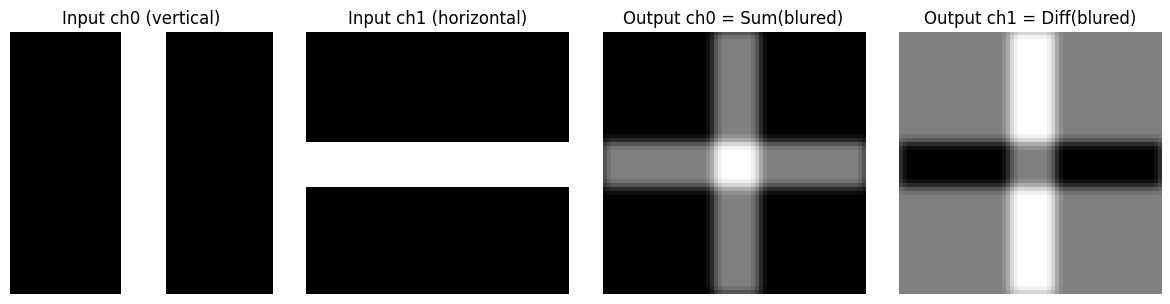

In [ ]:
import numpy as np


class MiniConvFFN(nn.Module):
    def __init__(self, k=5):
        super().__init__()
        self.dw = nn.Conv2d(2, 2, kernel_size=k, padding=k//2, groups=2, bias=False)
        self.pw = nn.Conv2d(2, 2, kernel_size=1, bias=False)
        self._init_weights()

    def _init_weights(self):
        # Depthwise ядро — блюр (пространственный mix)
        base = np.array([[1,2,3,2,1],
                         [2,4,6,4,2],
                         [3,6,9,6,3],
                         [2,4,6,4,2],
                         [1,2,3,2,1]], dtype=np.float32)
        base /= base.sum()
        k = torch.tensor(base).view(1,1,5,5)
        with torch.no_grad():
            self.dw.weight.copy_(k.repeat(2,1,1,1))
        # Pointwise ядро — смешивает каналы: sum и diff
        W = torch.tensor([[1, 1],
                          [1,-1]], dtype=torch.float32).view(2,2,1,1)
        with torch.no_grad():
            self.pw.weight.copy_(W)

    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        return x

# вход: вертикальная и горизонтальная полосы
H=W=64
yy, xx = np.mgrid[0:H, 0:W]
ch0 = (np.abs(xx - W//2) < 6).astype(np.float32)
ch1 = (np.abs(yy - H//2) < 6).astype(np.float32)
x = torch.from_numpy(np.stack([ch0, ch1], axis=0))[None]

layer = MiniConvFFN().eval()
with torch.no_grad():
    y = layer(x)
y0, y1 = y[0,0].numpy(), y[0,1].numpy()

fig, axs = plt.subplots(1,4,figsize=(12,3))
titles = ['Input ch0 (vertical)','Input ch1 (horizontal)',
          'Output ch0 = Sum(blured)','Output ch1 = Diff(blured)']
for i,img in enumerate([ch0,ch1,y0,y1]):
    axs[i].imshow(img, cmap='gray'); axs[i].set_title(titles[i]); axs[i].axis('off')
plt.tight_layout(); plt.show()


- **Depthwise 5×5** размывает полосы → это пространственный mix.
- **1×1 Conv** создаёт:
  - ch0 = сумма каналов (объединяет вертикаль + горизонталь),
  - ch1 = разность (подчёркивает места, где они пересекаются).
  
Это и есть смысл ConvFFN:
- Depthwise Conv отвечает за **локальный контекст**,
- 1×1 Conv — за **взаимодействие каналов**.

В FastViT то же самое, но с расширением-сжатием каналов и нелинейностью GELU.


# Визуальное внимание Qwen3-VL

Прооведем эксперимент по анализу внимания мультимодальной модели **Qwen3-VL**.  
Мы исследуем, **как модель распределяет внимание между визуальной и текстовой информацией** в процессе генерации ответа.


Цель - посмотреть, как **внимание модели к изображению (visual attention)** постепенно меняется в ходе рассуждения.  
Такой анализ вдохновлён [Look Again, Think Slowly: Enhancing Visual Reflection in
Vision-Language Models](https://arxiv.org/abs/2509.12132).

Авторы показывают, что модели сначала сильно опираются на изображение,
но по мере порождения текста внимание к нему **экспоненциально падает**.  
Мы воспроизводим этот эффект экспериментально. Отметим, что в фокусе работы - ризонинг, но мы можем попытаться его смоделировать на небольших моделях.



In [ ]:
import io, requests, numpy as np, matplotlib.pyplot as plt, pandas as pd
from dataclasses import dataclass
from PIL import Image
import torch
from transformers import (
    AutoProcessor, Qwen3VLForConditionalGeneration, set_seed
)
from IPython.display import HTML, display

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if torch.cuda.is_available() else torch.float32
set_seed(42)

MODEL_ID = "Qwen/Qwen3-VL-4B-Instruct"
MAX_NEW_TOKENS = 512

print(f"Device: {device}, dtype: {dtype}")

Device: cuda, dtype: torch.float16


 Мы включаем параметр `attn_implementation="eager"`, чтобы иметь доступ к картам внимания (`attentions`) на каждом шаге генерации.


In [ ]:
model = Qwen3VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype,
    device_map="auto",
    attn_implementation="eager",  # нужно для доступа к attention
)
model.config.output_attentions = True
processor = AutoProcessor.from_pretrained(MODEL_ID)

print("Модель загружена, режим внимания:", model.config._attn_implementation)

`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Модель загружена, режим внимания: eager


Мы подаём на вход изображение и текстовый запрос, оформленный в виде чата.  
Модель получает одновременно визуальные токены (эмбеддинги изображения) и текстовые токены.

Для анализа нам важно определить, где в последовательности токенов начинаются и заканчиваются **визуальные** токены (`visual_l` и `visual_r`),чтобы при вычислении внимания мы могли посчитать, **какая доля внимания направлена на изображение**.


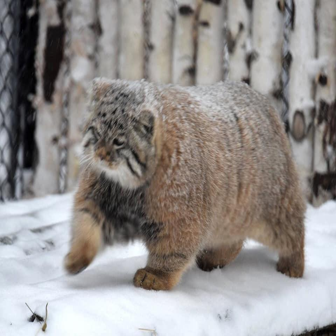

Visual tokens span: [4, 104) length=100


In [ ]:
IMG_URL = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
image = Image.open(io.BytesIO(requests.get(IMG_URL).content)).convert("RGB")
image = image.resize((336, 336))
display(image)

prompt = (
    "Analyze this photo step by step. "
    "1) Identify the main objects and attributes. "
    "2) Describe spatial relations. "
    "3) Infer what might have happened before. "
    "Think slowly and reason clearly."
)

messages = [{"role": "user", "content": [
    {"type": "image", "image": image},
    {"type": "text", "text": prompt}
]}]

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
)
inputs.pop("token_type_ids", None)
inputs = {k:(v.to(device) if isinstance(v, torch.Tensor) else v) for k,v in inputs.items()}

cfg = model.config
ids = inputs["input_ids"][0].tolist()
vs, ve = cfg.vision_start_token_id, cfg.vision_end_token_id
visual_l = ids.index(vs) + 1 if vs in ids else -1
visual_r = ids.index(ve) if ve in ids else -1
print(f"Visual tokens span: [{visual_l}, {visual_r}) length={visual_r-visual_l}")

В этом блоке реализован **ручной пошаговый цикл генерации** (`greedy decoding`).

На каждом шаге модель предсказывает следующий токен.  
Мы используем флаг `output_attentions=True`, чтобы извлечь **attention карты последнего слоя**.  

В модели Qwen3-VL каждый слой Transformer имеет матрицу внимания размером `[num_heads, target_len, source_len]`.  
Для последнего генерируемого токена (`target_len = 1`) мы усредняем внимание по головам (`mean(dim=0)`),  
и вычисляем, **какая доля общей суммы внимания приходится на визуальные токены** — это и есть `visual attention ratio`.

Этот цикл повторяет внутренний механизм `generate()` в Transformers, но добавляет мониторинг внимания.


In [ ]:
@dataclass
class StepStat:
    step: int
    token_id: int
    token_str: str
    ratio: float

@torch.no_grad()
def greedy_with_attn_trace_exact(model, inputs, visual_l, visual_r, max_new_tokens):
    """
    Полностью повторяет поведение generate(do_sample=False)
    и сохраняет внимание последнего слоя по каждому шагу.
    """
    stats, traced_ids = [], []
    model_kwargs = {k: v for k, v in inputs.items()}
    input_ids = model_kwargs.pop("input_ids")
    model_kwargs["cache_position"] = torch.arange(
        0, input_ids.shape[1], dtype=torch.long, device=input_ids.device
    )
    model_kwargs["past_key_values"] = None

    for step in range(max_new_tokens):
        prepared = model.prepare_inputs_for_generation(
            input_ids=input_ids,
            **model_kwargs,
        )
        outputs = model(
            **prepared,
            output_attentions=True,
            return_dict=True,
        )

        attn_last = outputs.attentions[-1]
        a = attn_last[0, :, -1, :].mean(0)
        ratio = float((a[visual_l:visual_r].sum() / a.sum()).item()) if (visual_l>=0 and visual_r>visual_l) else float("nan")

        logits = outputs.logits[:, -1, :]
        next_token = torch.argmax(logits, dim=-1, keepdim=True)

        tok_str = processor.tokenizer.decode(next_token[0], skip_special_tokens=False)
        stats.append(StepStat(step, int(next_token.item()), tok_str, ratio))
        traced_ids.append(int(next_token.item()))

        model_kwargs = model._update_model_kwargs_for_generation(
            outputs=outputs, model_kwargs=model_kwargs, is_encoder_decoder=False,
        )
        if "cache_position" not in model_kwargs or model_kwargs["cache_position"] is None:
            last_pos = step + input_ids.shape[1]
            model_kwargs["cache_position"] = torch.arange(
                last_pos, last_pos + 1, dtype=torch.long, device=input_ids.device
            )

        input_ids = next_token
        del outputs, attn_last, a, logits
        torch.cuda.empty_cache()
    return stats, traced_ids

In [ ]:
torch.cuda.empty_cache()
trace_exact, ids_exact = greedy_with_attn_trace_exact(
    model, inputs, visual_l, visual_r, max_new_tokens=MAX_NEW_TOKENS
)
decoded_from_trace = processor.tokenizer.decode(ids_exact, skip_special_tokens=True)

In [ ]:
print(decoded_from_trace)

Let’s analyze this photo step by step, as requested.

—

1) Identify the main objects and attributes.

- Main object: A small, short-legged, stocky mammal — likely a Pallas’s cat (Otocolobus manul), also known as the “manul” or “snow cat.” This is identifiable by its thick, fluffy fur, large round ears, and distinctive facial markings.
- Attributes of the animal:
  - Covered in light snow, especially on its back and head — suggesting recent snowfall or cold weather.
  - Fur is mottled brown, gray, and white, providing camouflage in snowy, birch forest environments.
  - Eyes are closed or squinting — possibly due to cold, wind, or the animal’s natural behavior when moving.
  - Legs are short and sturdy, with paws that appear adapted for walking on snow.
  - The animal is in motion — one front paw is lifted mid-step, indicating it is walking or trotting.
- Background:
  - A cluster of birch trees with white bark and dark vertical markings — typical of boreal or subarctic forests.
  - Sno

Построим график изменения `visual attention ratio` в процессе генерации.

Каждая точка — отдельный токен, а красная линия — сглаженная кривая (скользящее среднее).


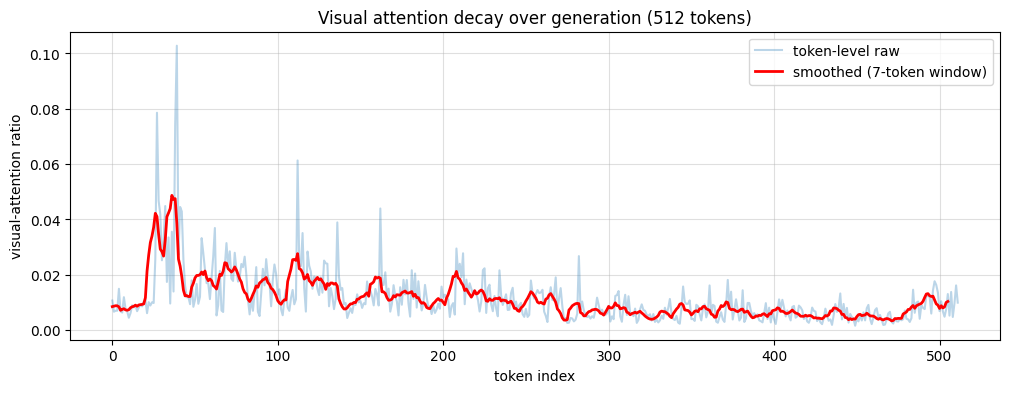

In [ ]:
ratios = [s.ratio for s in trace_exact]
tokens = [s.token_str for s in trace_exact]

def smooth(x, w=5):
    k = np.ones(w)/w
    return np.convolve(x, k, mode="valid")

plt.figure(figsize=(12,4))
plt.plot(ratios, alpha=0.3, label="token-level raw")
plt.plot(smooth(ratios,7), color="red", linewidth=2, label="smoothed (7-token window)")
plt.xlabel("token index")
plt.ylabel("visual-attention ratio")
plt.title("Visual attention decay over generation (512 tokens)")
plt.legend(); plt.grid(True, alpha=0.4)
plt.show()

Наблюдается **эффект затухания** — внимание к изображению падает, когда модель переходит от описания объектов к рассуждениям.

Это подтверждает гипотезу статей *Visual Reflection Decay* и *Look Again and Think Slowly*.

Поскольку один "токен" — это не обязательно одно слово, мы группируем соседние токены в слова по префиксу.  
Для каждого слова усредняем внимание по всем его токенам.

Это делает графики более понятными — теперь мы видим осмысленные слова, а не фрагменты.


In [ ]:
words, word_ratios = [], []
cur_word, cur_vals = "", []
for tok, r in zip(tokens, ratios):
    if tok.startswith(" ") and cur_word:
        words.append(cur_word.strip())
        word_ratios.append(np.mean(cur_vals))
        cur_word, cur_vals = "", []
    cur_word += tok
    cur_vals.append(r)
if cur_word:
    words.append(cur_word.strip())
    word_ratios.append(np.mean(cur_vals))

print(f"{len(words)} words, {len(ratios)} tokens traced")

392 words, 512 tokens traced


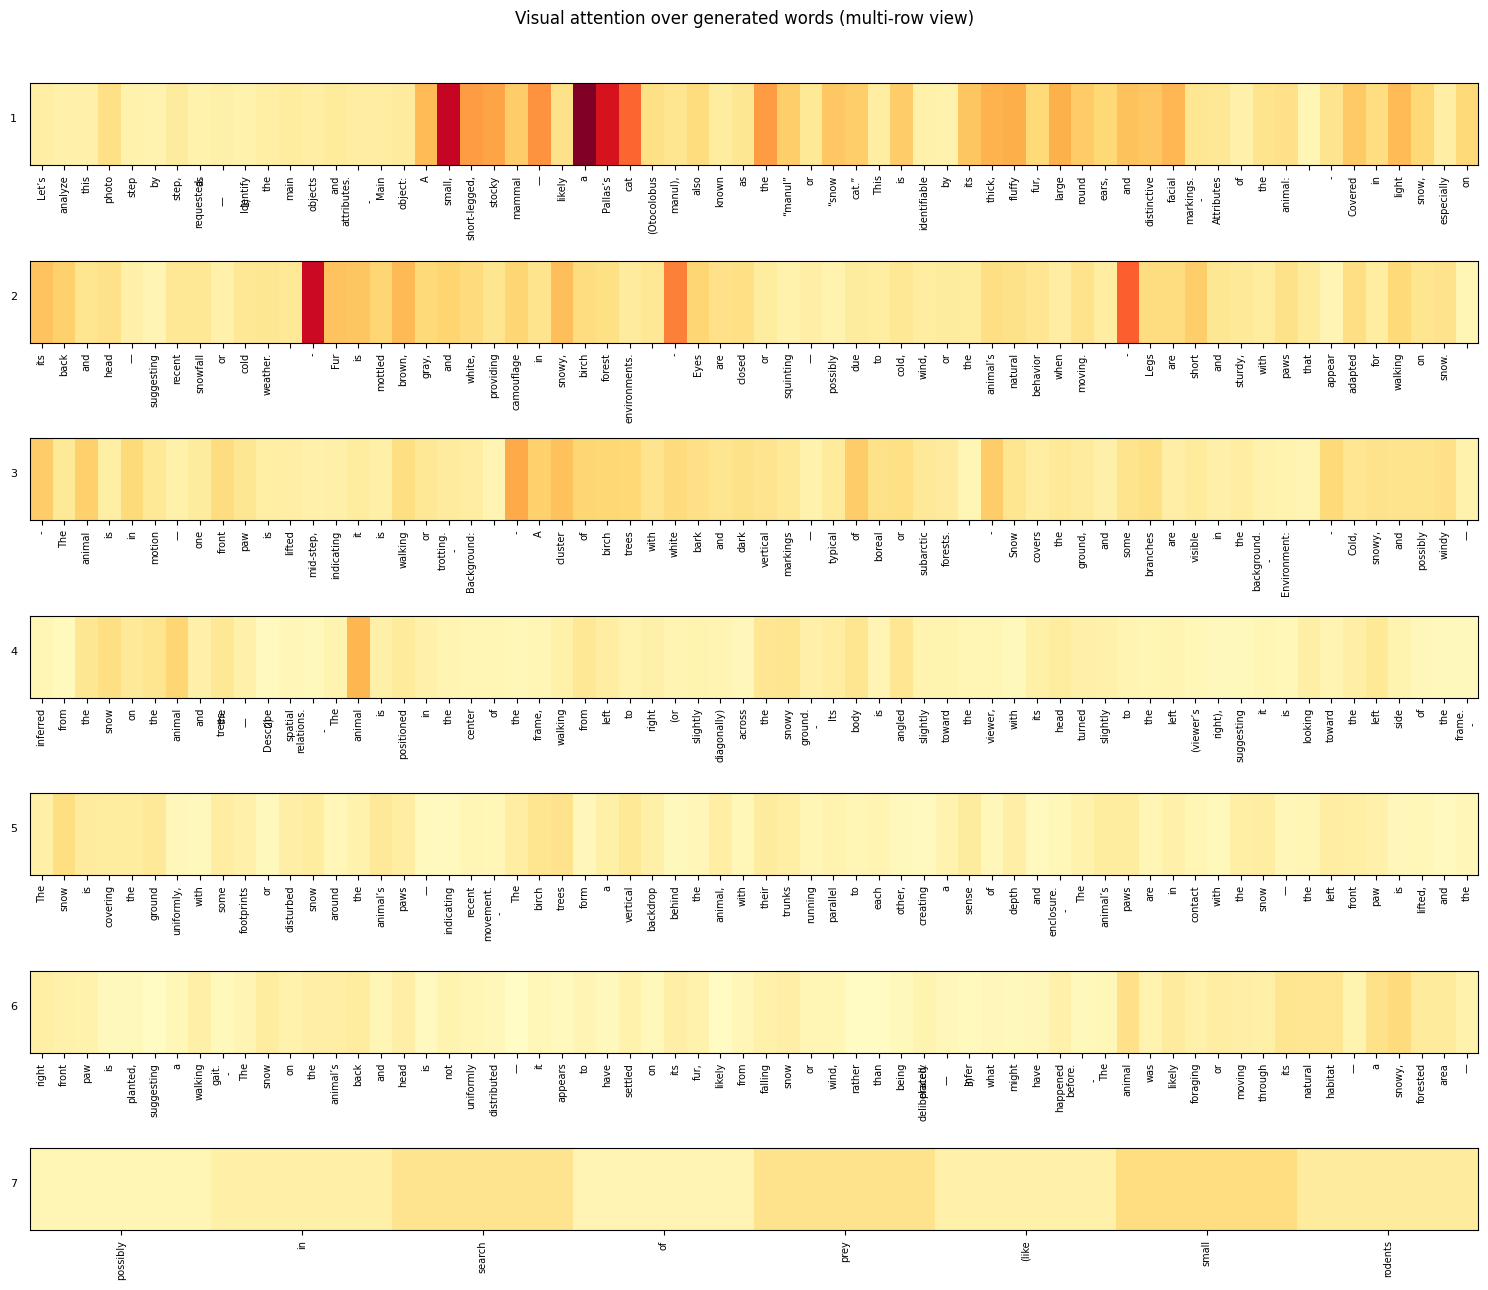

In [ ]:
max_per_row = 64
num_rows = int(np.ceil(len(words) / max_per_row))

fig, axes = plt.subplots(num_rows, 1, figsize=(15, num_rows * 1.8))
if num_rows == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    start = i * max_per_row
    end = min((i + 1) * max_per_row, len(words))
    segment = word_ratios[start:end]

    ax.imshow([segment], cmap="YlOrRd", aspect="auto", vmin=0, vmax=max(word_ratios))
    ax.set_xticks(range(len(segment)))
    ax.set_xticklabels(words[start:end], rotation=90, fontsize=7)
    ax.set_yticks([])
    ax.set_ylabel(f"{i+1}", rotation=0, labelpad=12, fontsize=8)
    ax.set_xlim(-0.5, len(segment) - 0.5)

# убираем общий colorbar — опционально можно добавить маленький сбоку:
# sm = plt.cm.ScalarMappable(cmap="YlOrRd")
# fig.colorbar(sm, ax=axes[-1], fraction=0.02, pad=0.02, orientation="horizontal")

plt.suptitle("Visual attention over generated words (multi-row view)", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()


Ну или более фэнси вариант.

In [ ]:
from IPython.display import HTML

def color_word(w, r):
    # r \in [0, 1], ограничим диапазон яркости
    r = max(0.0, min(1.0, r))
    # Градиент от белого (0) к насыщенно-оранжевому (1)
    hue = 15       # фиксируем оттенок (оранжевый)
    light = 100 - int(100 * r)  # яркость (чем выше внимание, тем темнее)
    sat = 90                  # насыщенность
    return f'<span style="background-color:hsl({hue},{sat}%,{light}%);padding:2px;border-radius:3px;">{w}</span>'

colored = " ".join(color_word(w, r) for w, r in zip(words, word_ratios))
display(HTML(f"""
<div style='font-family:monospace;line-height:1.6em;
            background-color:#fff;border-radius:6px;padding:10px;
            width:95%;'>
{colored}
</div>
"""))


## Что посмотреть далее

Несколько направлений и репозиториев, которые не вошли в семинар, но стоит посмотреть:

- **[VLM2VEC v1](https://github.com/TIGER-AI-Lab/VLM2Vec/tree/v1)** — базовая версия, где VLM используется как feature extractor.  
  Посмотрите, как реализовано агрегирование визуальных токенов и варианты визуального pooling.  
  _На Colab может не завестись из-за зависимостей, но код лёгкий для локального запуска._

- **[VLM2VEC v2](https://github.com/TIGER-AI-Lab/VLM2Vec/tree/main)** — переработанная версия с новым токенайзером и унифицированным интерфейсом для разных VLM.  
  Хороший пример того, как «тяжёлые» модели превращаются в удобные энкодеры для retrieval-задач.  
  _Требует больше GPU-памяти ._

- **[Unified Model for Multimodal Understanding and Generation (BAGEL)](https://github.com/ByteDance-Seed/Bagel/tree/main)** — пример truly any-to-any модели, где текст и визуальные токены обрабатываются совместно.  
  Обратите внимание на реализацию **sequence interleaving**, **discrete visual tokens** и **mask-based generation** — это ядро современных MLLM.  
  _Запуск на Colab ограничен по ресурсам, но код можно изучать офлайн._

- **[Qwen3-VL cookbooks](https://github.com/QwenLM/Qwen3-VL/tree/main/cookbooks)** — практические «рецепты» для OCR, reasoning, визуального QA, таблиц и fine-grained grounding.  
  Отличный источник идей для собственных экспериментов и мини-проектов.

- Изучите реализации 2D-RoPE, m-RoPE, etc в [сурсах Qwen3-VL](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen3_vl/modeling_qwen3_vl.py).

